In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [2]:
df=pd.read_csv("C:/Users/User/Downloads/New Folder/RAVDESS_Features.csv")
df.head()

MFCC 1  MFCC 2   MFCC 3   MFCC 4    MFCC 5    MFCC 6    MFCC 7    MFCC 8  \
0  -97.120  1.3176  0.18176  0.50807  0.099727  0.181770  0.165050 -0.202920   
1 -347.120  1.4959  0.11864  0.44347 -0.013795  0.204390 -0.157960  0.031897   
2  -21.704  1.7307  0.25501  0.73880  0.289550  0.168680 -0.132630 -0.011474   
3 -334.250  1.4186  0.18240  0.35081  0.017216  0.176780 -0.098481 -0.022925   
4  -21.199  1.8364 -0.29819  0.62589 -0.006188 -0.006973  0.062850 -0.196910   

     MFCC 9   MFCC 10  ...  Std LPC       ZCR  Total Energy  Mean Energy  \
0  0.002517 -0.003009  ...  0.70922  0.069835        84.325      0.46847   
1 -0.007192  0.053992  ...  0.63281  0.061181        51.680      0.30222   
2 -0.035342 -0.022232  ...  0.70171  0.095855         6.285      0.03379   
3  0.062715 -0.026568  ...  0.58233  0.070625        72.544      0.42177   
4 -0.004470  0.109770  ...  0.73592  0.066838       119.340      0.66302   

   Std Energy   Pitch  Intensity      HNR       RMS  Label  
0    1.090000  198.19      0.000  25.0230  0.008102  Angry  
1    0.846220  269.78      0.000   9.2184  0.006518  Angry  
2    0.089036  179.50     53.655  10.6800  0.002264  Angry  
3    1.343000  251.28      0.000  16.3970  0.007359  Angry  
4    1.404100  275.50     58.117  12.9430  0.010257  Angry  

[5 rows x 121 columns]

In [3]:
df.shape

(960, 121)

In [4]:
class_counts = df['Label'].value_counts()

In [5]:
class_counts

Angry      192
Disgust    192
Fearful    192
Happy      192
Sad        192
Name: Label, dtype: int64

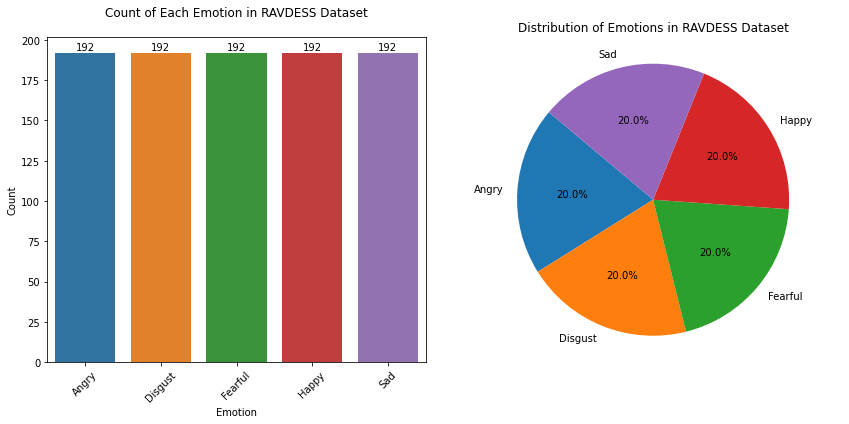

In [6]:
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the bar plot on the first subplot
sns.countplot(x='Label', data=df, order=class_counts.index, ax=axs[0])
axs[0].set_xlabel('Emotion')
axs[0].set_ylabel('Count')
axs[0].set_title('Count of Each Emotion in RAVDESS Dataset\n')
axs[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
# Get bar counts
bar_counts = axs[0].containers[0]
# Add annotations (class counts) on top of each bar
for bar, count in zip(bar_counts, class_counts):
    yval = bar.get_height()  # Get the height of each bar
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, count, ha='center', va='bottom')  # Add text annotation with class count

# Plot the pie chart on the second subplot
axs[1].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Distribution of Emotions in RAVDESS Dataset')
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [7]:
X = df.iloc[:,:-1]
y = df['Label']

In [7]:
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

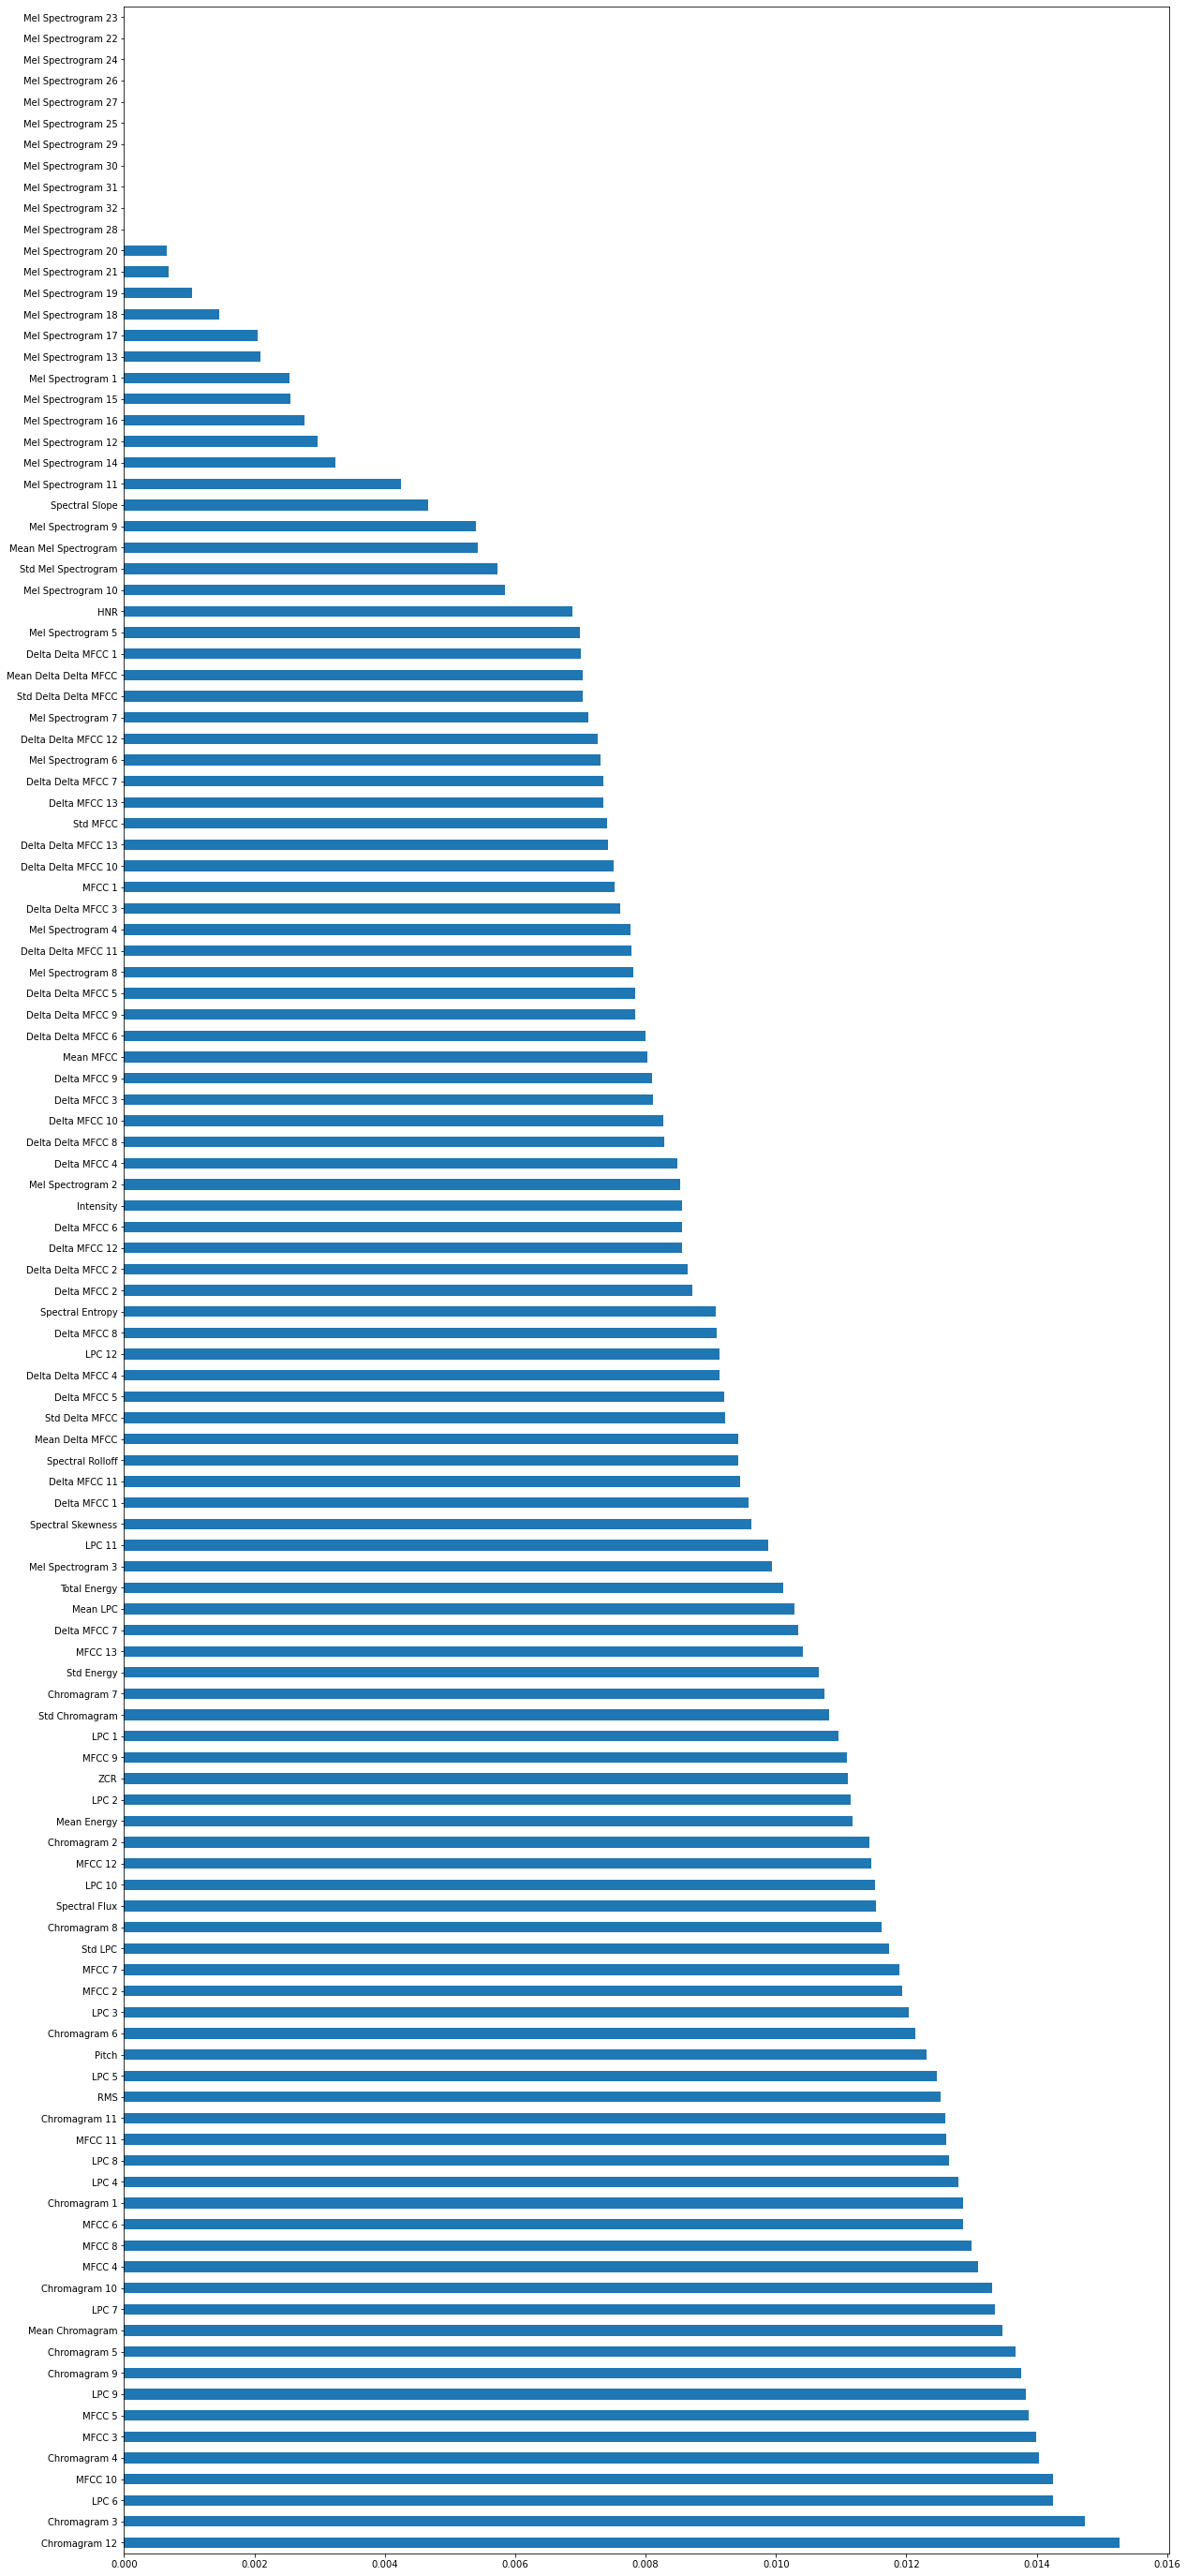

In [8]:
fea = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(20, 50))
fea.nlargest(120).plot(kind='barh')
plt.show()

In [9]:
selected_features = fea.nlargest(30).index

X = X[selected_features]
y = df['Label']

In [10]:
selected_features

Index(['Chromagram 12', 'Chromagram 3', 'LPC 6', 'MFCC 10', 'Chromagram 4',
       'MFCC 3', 'MFCC 5', 'LPC 9', 'Chromagram 9', 'Chromagram 5',
       'Mean Chromagram', 'LPC 7', 'Chromagram 10', 'MFCC 4', 'MFCC 8',
       'MFCC 6', 'Chromagram 1', 'LPC 4', 'LPC 8', 'MFCC 11', 'Chromagram 11',
       'RMS', 'LPC 5', 'Pitch', 'Chromagram 6', 'LPC 3', 'MFCC 2', 'MFCC 7',
       'Std LPC', 'Chromagram 8'],
      dtype='object')

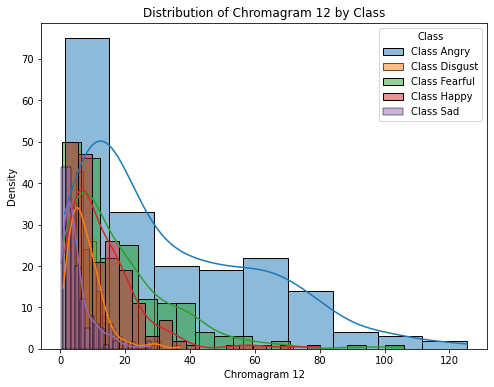

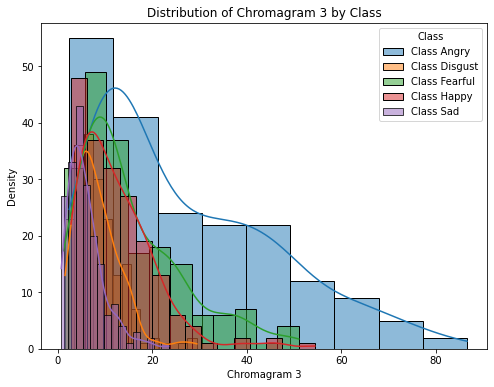

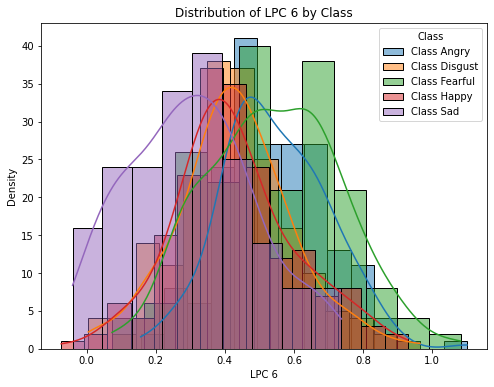

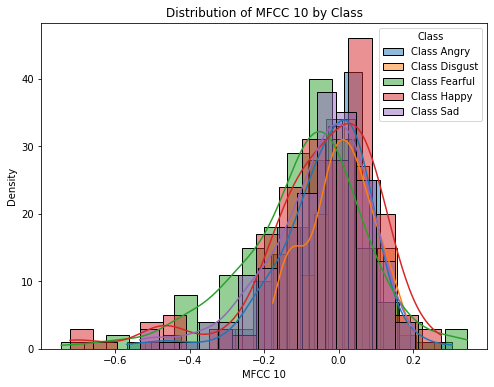

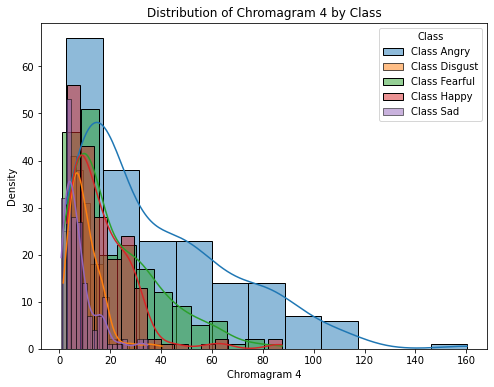

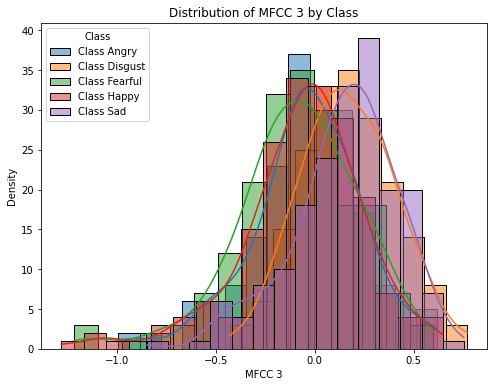

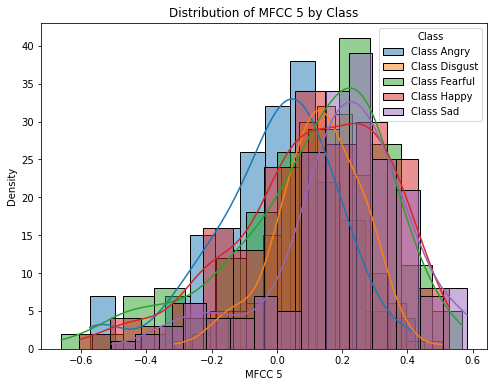

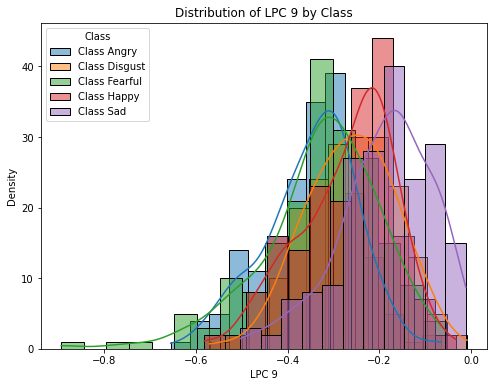

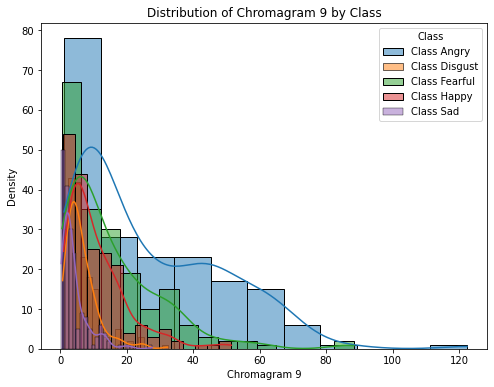

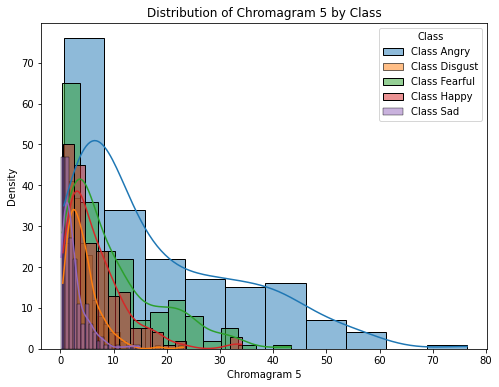

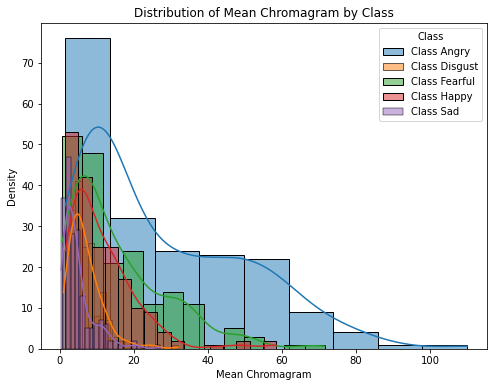

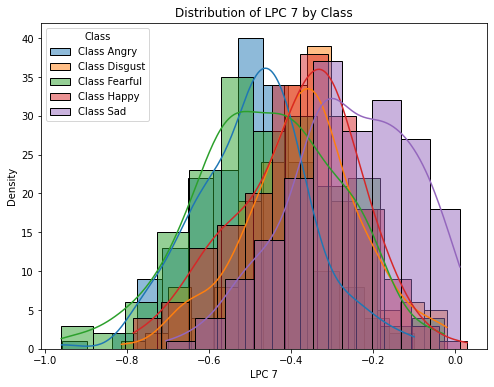

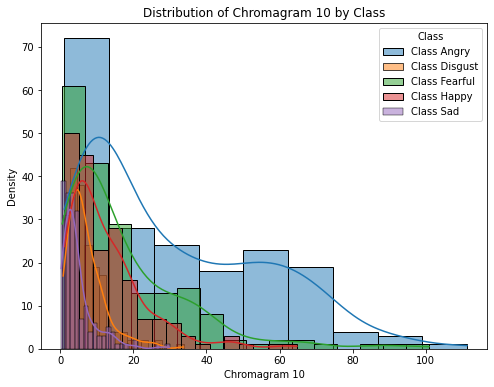

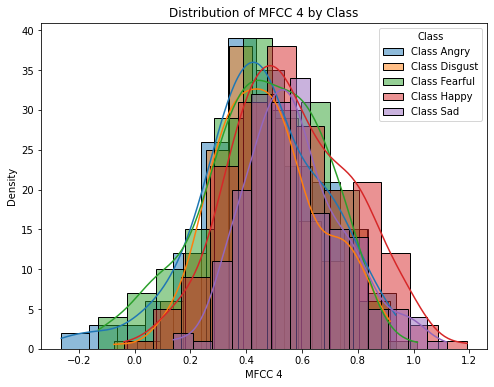

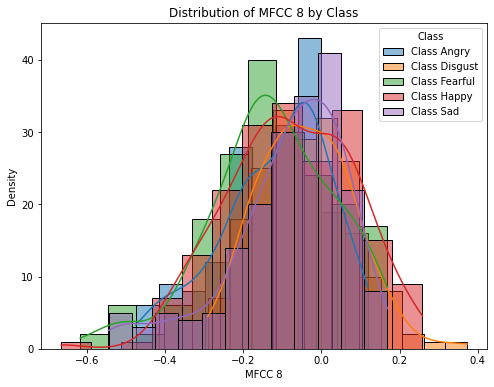

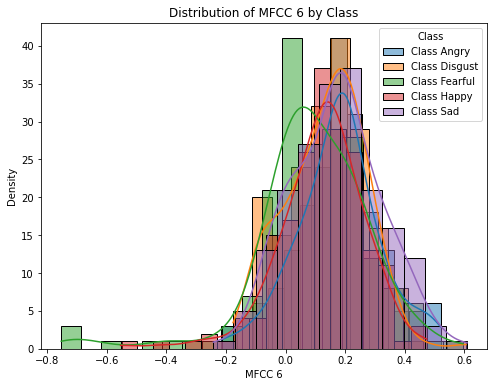

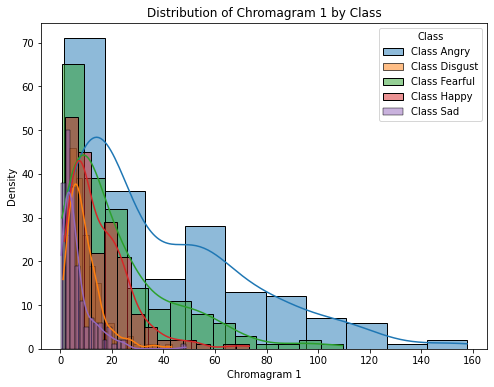

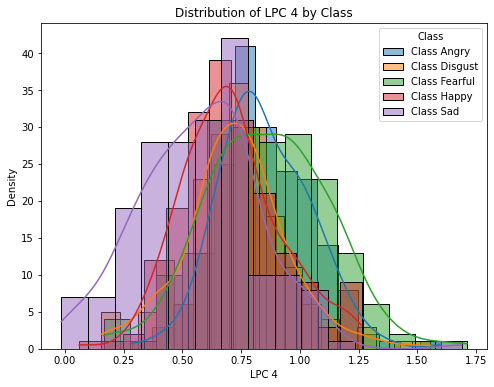

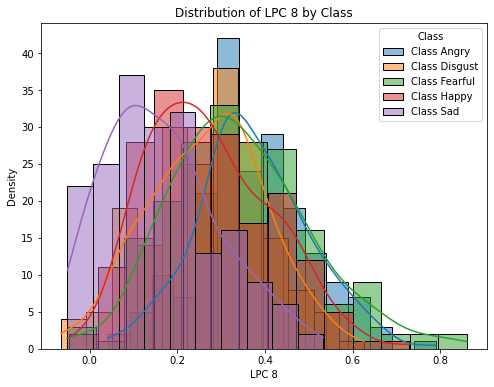

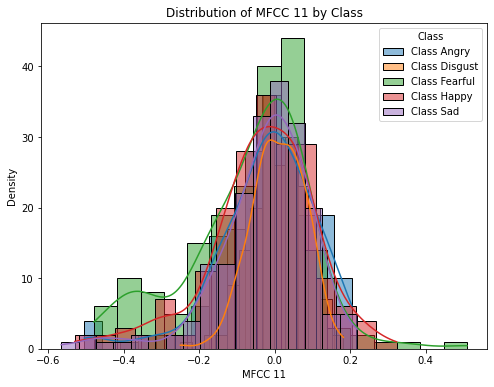

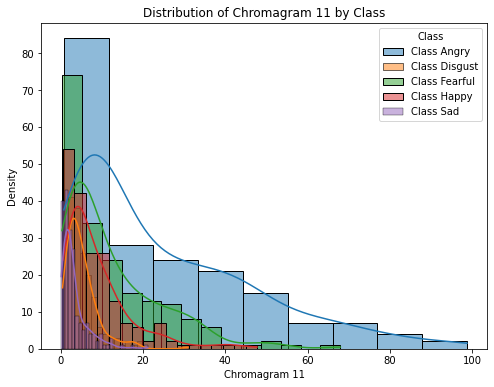

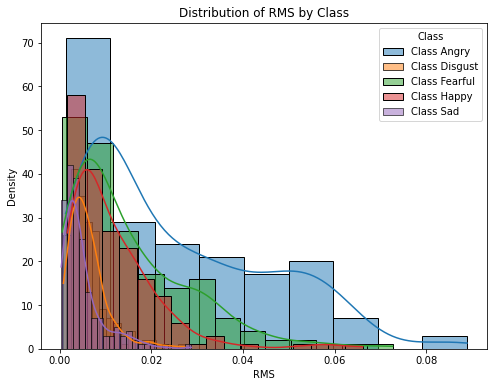

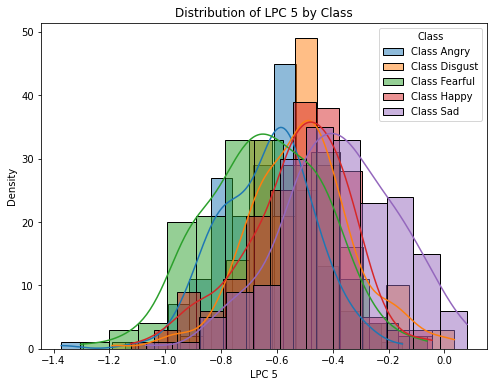

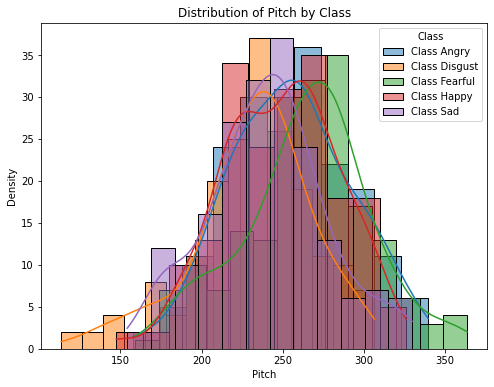

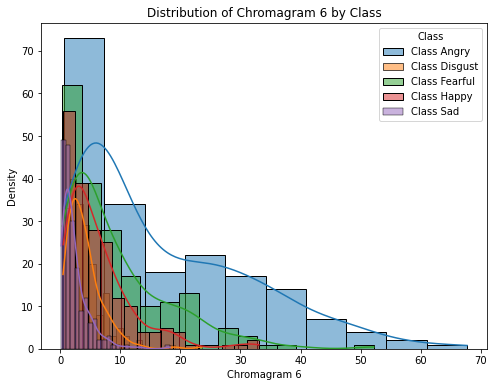

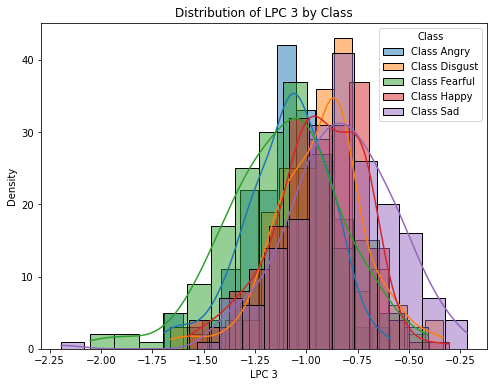

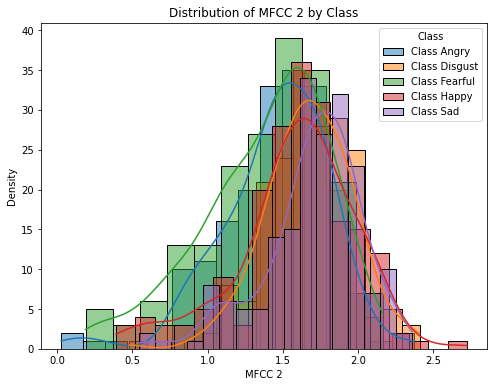

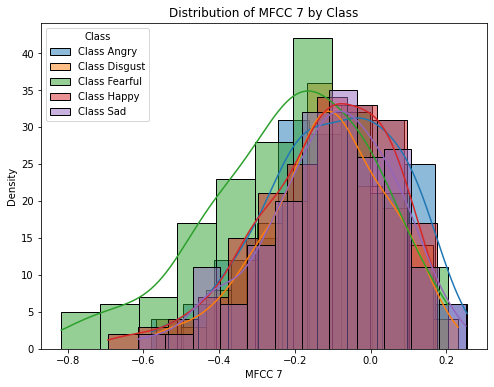

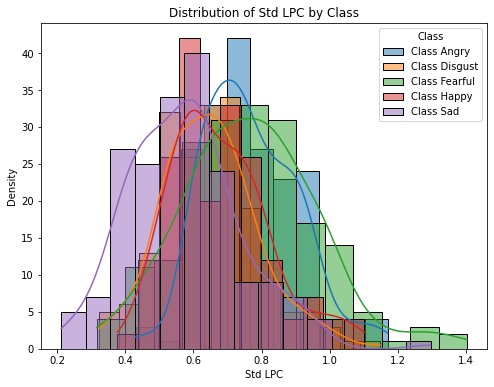

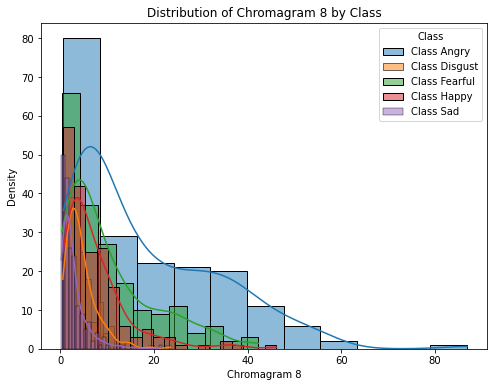

In [11]:
# Concatenate X and y into a single array for easier manipulation
data = np.column_stack((X, y))

# Get the number of features
num_features = X.shape[1]

# Define a custom color palette with 5 distinct colors
custom_palette = sns.color_palette("tab10", 5)

# Iterate over each feature and plot its distribution for each class
for i, feature_name in enumerate(selected_features):
    plt.figure(figsize=(8, 6))
    for label, color in zip(np.unique(y), custom_palette):
        sns.histplot(data[data[:, -1] == label, i], kde=True, label=f'Class {label}', color=color)
    plt.title(f'Distribution of {feature_name} by Class')
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.legend(title='Class')
    plt.show()

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
# Initialize variables for best accuracy, C, gamma, model, best training and testing data
best_accuracy = 0
best_C = None
best_gamma = None
best_model = None
best_X_train = None
best_X_test = None
best_y_train = None
best_y_test = None

no_improvement_count = 0  # Initialize the count for no improvement

C_values = np.arange(1, 21, 0.1)
gamma_values = np.arange(0.01, 1.01, 0.01)

while no_improvement_count < 100:  # Set the maximum number of iterations without improvement
    for C in C_values:  # Iterate over C values from 1 to 15
        for gamma in gamma_values:  # Iterate over gamma values from 0.01 to 1
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
            
            # Initialize and train the SVM classifier
            svm = SVC(kernel='rbf', C=C, gamma=gamma)
            svm.fit(X_train, y_train)

            # Predict on the testing data
            y_pred = svm.predict(X_test)
            
            # Calculate accuracy
            acc = accuracy_score(y_test, y_pred)
            
            # Check if the current accuracy is better than the best accuracy
            if acc > best_accuracy:
                best_accuracy = acc
                best_C = C
                best_gamma = gamma
                best_model = svm
                best_X_train = X_train
                best_X_test = X_test
                best_y_train = y_train
                best_y_test = y_test
                
                no_improvement_count = 0
                
                print("Best accuracy so far:", best_accuracy)
                print("Best C value so far:", best_C)
                print("Best gamma value so far:", best_gamma)
            else:
                # Increment the count if there's no improvement
                no_improvement_count += 1

# Save the best model
joblib.dump(best_model, 'RAVDESS Model.joblib')

# Save the best training and testing data
joblib.dump(best_X_train, 'X_train.joblib')
joblib.dump(best_X_test, 'X_test.joblib')
joblib.dump(best_y_train, 'y_train.joblib')
joblib.dump(best_y_test, 'y_test.joblib')
                
# After the loop finishes, print the final best accuracy and the corresponding C and gamma values
print("Final best accuracy:", best_accuracy)
print("Final best C value:", best_C)
print("Final best gamma value:", best_gamma)

Best accuracy so far: 0.5989583333333334
Best C value so far: 1.0
Best gamma value so far: 0.01
Best accuracy so far: 0.640625
Best C value so far: 1.0
Best gamma value so far: 0.05
Best accuracy so far: 0.6927083333333334
Best C value so far: 1.0
Best gamma value so far: 0.06999999999999999
Best accuracy so far: 0.71875
Best C value so far: 1.0
Best gamma value so far: 0.08
Best accuracy so far: 0.7239583333333334
Best C value so far: 1.0
Best gamma value so far: 0.14
Best accuracy so far: 0.7760416666666666
Best C value so far: 1.0
Best gamma value so far: 0.21000000000000002
Best accuracy so far: 0.796875
Best C value so far: 1.1
Best gamma value so far: 0.33
Best accuracy so far: 0.8020833333333334
Best C value so far: 2.200000000000001
Best gamma value so far: 0.32
Best accuracy so far: 0.828125
Best C value so far: 2.4000000000000012
Best gamma value so far: 0.15000000000000002
Best accuracy so far: 0.8541666666666666
Best C value so far: 4.600000000000003
Best gamma value so far

In [9]:
# Load the saved model
model = joblib.load('RAVDESS Model.joblib')

# Load the saved training and testing data
X_train = joblib.load('X_train.joblib')
X_test = joblib.load('X_test.joblib')
y_train = joblib.load('y_train.joblib')
y_test = joblib.load('y_test.joblib')

In [10]:
# Predict on the test data
y_pred = model.predict(X_test)

In [11]:
# Generate the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

       Angry       0.92      0.90      0.91        39
     Disgust       0.82      0.84      0.83        38
     Fearful       0.86      0.84      0.85        38
       Happy       0.88      0.77      0.82        39
         Sad       0.80      0.92      0.85        38

    accuracy                           0.85       192
   macro avg       0.86      0.85      0.85       192
weighted avg       0.86      0.85      0.85       192



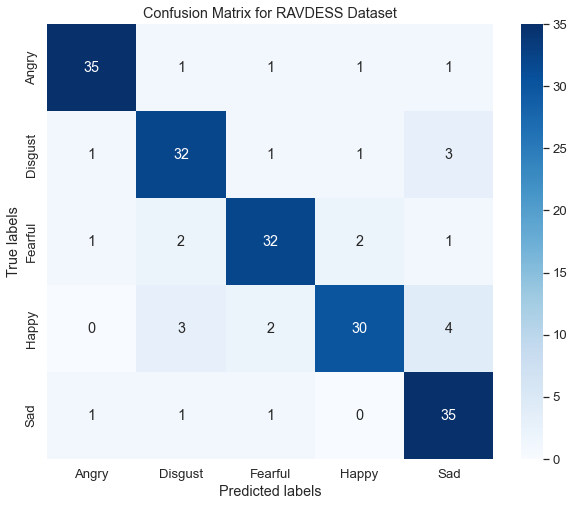

In [12]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get class labels
classes = model.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for RAVDESS Dataset')
plt.show()

In [13]:
# Calculate accuracy of each class
class_accuracies = {}
for i, cls in enumerate(classes):
    # True positives for class i
    TP = cm[i, i]
    # Total instances for class i
    total_instances = np.sum(cm[i, :])
    # Accuracy for class i
    class_accuracy = TP / total_instances
    class_accuracies[cls] = class_accuracy

# Print class-wise accuracies
print("Class-wise Accuracies:")
for cls, accuracy in class_accuracies.items():
    print(f"{cls}: {accuracy:.2f}")

Class-wise Accuracies:
Angry: 0.90
Disgust: 0.84
Fearful: 0.84
Happy: 0.77
Sad: 0.92


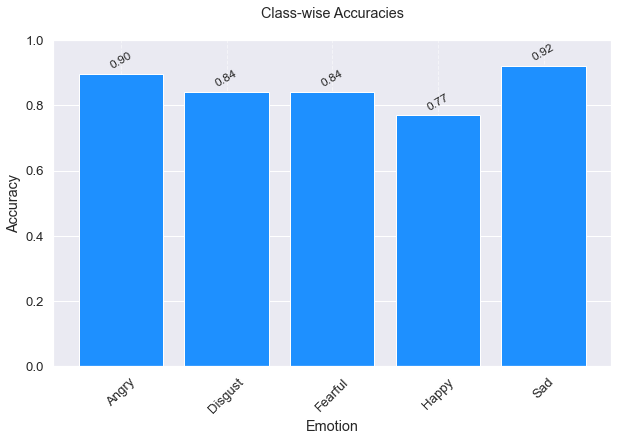

In [15]:
# Extract class labels and accuracies
class_labels = list(class_accuracies.keys())
accuracies = list(class_accuracies.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_labels, accuracies, color='dodgerblue')
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracies\n')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for better visualization
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add horizontal grid lines
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=12, rotation=30)
plt.show()

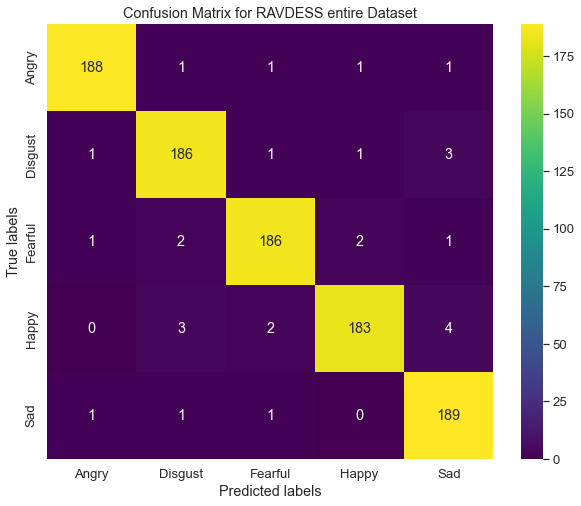

In [20]:
# Generate predictions for the entire dataset
y_pred_full = model.predict(X)

# Generate the confusion matrix
cm_full = confusion_matrix(y, y_pred_full)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(cm_full, annot=True, cmap='viridis', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for RAVDESS entire Dataset')
plt.show()

In [21]:
# Calculate accuracy of each class
class_accuracies = {}
for i, cls in enumerate(classes):
    # True positives for class i
    TP = cm_full[i, i]
    # Total instances for class i
    total_instances = np.sum(cm_full[i, :])
    # Accuracy for class i
    class_accuracy = TP / total_instances
    class_accuracies[cls] = class_accuracy

# Print class-wise accuracies
print("Class-wise Accuracies:")
for cls, accuracy in class_accuracies.items():
    print(f"{cls}: {accuracy:.2f}")

Class-wise Accuracies:
Angry: 0.98
Disgust: 0.97
Fearful: 0.97
Happy: 0.95
Sad: 0.98


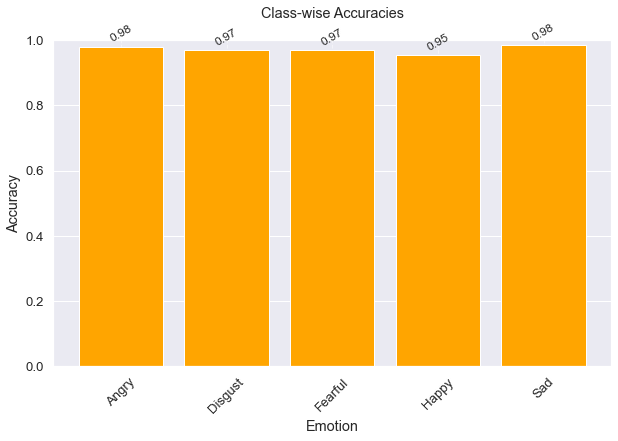

In [22]:
# Extract class labels and accuracies
class_labels = list(class_accuracies.keys())
accuracies = list(class_accuracies.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_labels, accuracies, color='orange')
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracies\n')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for better visualization
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add horizontal grid lines
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=12, rotation=30)
plt.show()